In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from utils import *
from plotutils import *
from pymc3 import model_to_graphviz
plt.style.use("fivethirtyeight")

C:\Users\tanve\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\tanve\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


We will implement the eight schools problem from Section 5.5 in Gelman et al. 2013 and compare traditional methods vs. the new method proposed in the Vehtari et al. 2019 paper.

In this problem, the Educational Testing Services company studied the effects of coaching on SAT scores.

In [2]:
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

In [3]:
with pm.Model() as centered:

    mu = pm.Normal('mu', 0, 5)
    tau = pm.Cauchy('tau', 0, 5)

    theta = pm.Normal('theta', mu, tau, shape = len(y))
    obs = pm.Normal('obs', theta, sigma=sigma, observed=y)

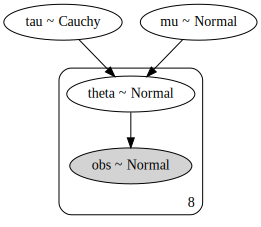

In [4]:
model_to_graphviz(centered)

In [39]:
with centered:
    trace = pm.sample(1000, cores=1, chains = 4, target_accept = 0.975, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [theta, tau, mu]
  0%|          | 0/2000 [00:00<?, ?it/s]


SamplingError: Bad initial energy

As we see here, there were significant divergences even after increasing ``target_accept`` to $0.975$. This tells us that the posterior is not well-behaved. 

Now we save the trace for future use:

In [9]:
#savetrace("centered_model.pkl", trace, centered)

We can also load the file in the following way:

In [11]:
centered, trace = loadtrace("centered_model.pkl")

Now, we check the trace of the parameter $\tau$. This one is of interest because it is drawn from the Cauchy distribution which does not have a defined mean.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019D9E8EC048>,
      dtype=object)

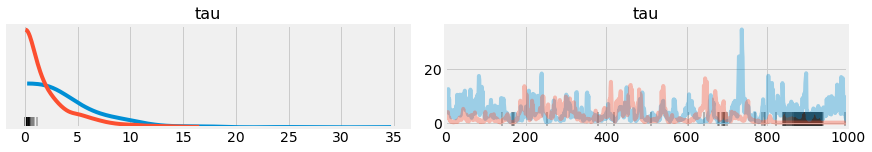

In [29]:
pm.traceplot(trace, var_names=['tau'])

We can explore the same samples but with burnin and thinning. We pick a burnin of $10$% and thinning of $10$.

In [30]:
burnin = 0.1
burn_idx = int(burnin*len(trace))
thin = 10

trace = trace[burn_idx::thin]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019D9DBB7BA8>,
      dtype=object)

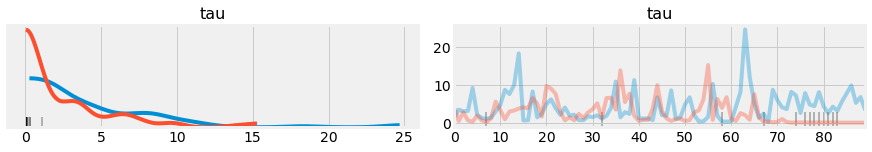

In [31]:
pm.traceplot(trace, var_names=['tau'])

The traceplots show some autocorrelation but it is not quite clear from the KDEs whether we are drawing samples from the same distribution. Thus, we implement the rankplot scheme:

In [32]:
traces_by_chain = np.array(trace.get_values("tau", combine = False)) #split trace into chains
traces_by_chain.shape

(2, 90)

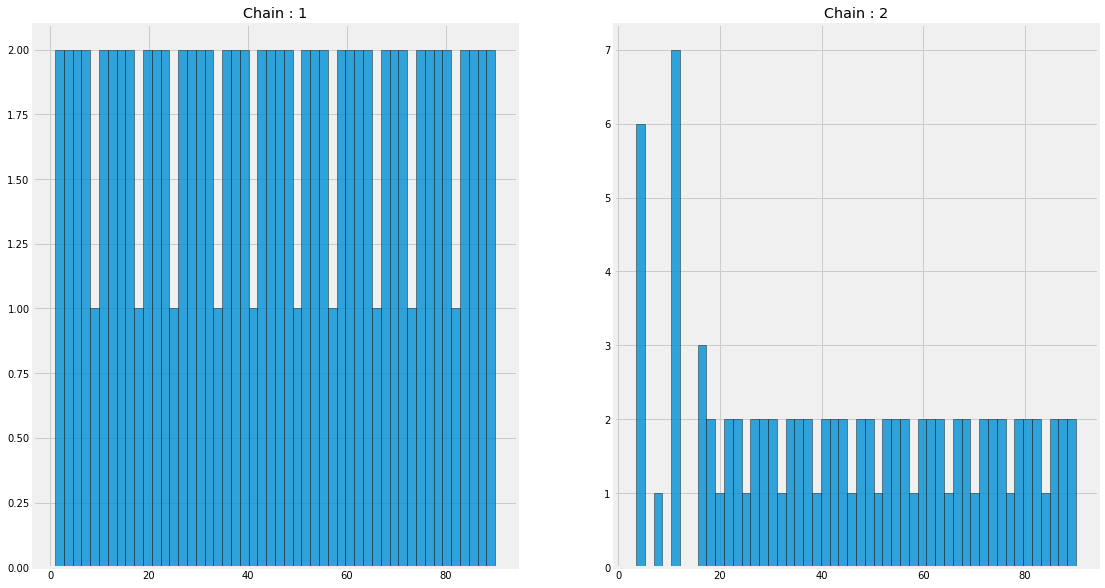

In [34]:
rankplot(traces_by_chain, 2, 1, 2)